# Introduction to Deep Learning

### Hands-on 2a: MNIST
Filippo Vicentini and Giuseppe Carleo

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/Lectures/blob/master/2111_Como-intro-to-deeplearning/2a-mnist.ipynb) 

#### Link to the GitHub repository:
https://github.com/PhilipVinc/IntroDeepLearning

or 

https://bit.ly/3ki90ki

---------------

The objective of this hands-on is to write and optimise an image-classifier that identifies handwritten digits.

We will use for this the [MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/)

![title](images/mnist.png)

## 0 - Install Requirements

For this example notebook we will need jax+flax+optax for the machine-learning part.

For the dataset, instead, we will be using `tensorflow_datasets`, which is a submodule of `tensorflow` that makes it easy to download and load into memory large datasets (such as MNIST and many others).

If you are running notebook locally, you need to also install `tensorflow` to make `tensorflow_datasets` work.

In [1]:
# Requirements
#!pip install tensorflow_datasets flax jax optax tqdm

### 0.1 - Utility Functions

Don't look here. There is nothing interesting.

In [3]:
# Utility functions (don't worry. you don't need to understand this one)

from matplotlib import pyplot as plt

def show_img(img, ax=None, title=None):
  """Shows a single image.
  
  Must be stored as a 3d-tensor where the last dimension is 1 channel (greyscale)
  """
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

In [4]:
# Import 
import jax
import jax.numpy as jnp

import numpy as np

## 1 - Setting up the dataset
First of all, we need to download the dataset.

The MNIST dataset is a standard dataset composed of several 28x28 black/white images representing numbers, and a label corresponding to the number that is represented there.

In [2]:
# We use Tensorflow datasets to download and import data in a simple numpy-tensor format
# It's just handy. You could use anything else.

import tensorflow_datasets as tfds

# Specify the dataset we are interested in
ds_builder = tfds.builder('mnist')

# Download the data
ds_builder.download_and_prepare()

# Get the whole dataset's train set
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


2021-09-17 14:35:43.177745: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.
2021-09-17 14:35:43.222810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


The dataset is split into two sub-sets: the training dataset that we will use to 'train' our model, and the 'test' dataset, which the model *never sees* during training, but that we use to check that the model performs well.

This is to verify that the model does not simply learn _by heart_ the images in the training dataset, but that it actually _learns_ to generalize and works correctly with images that he did not see before.

We can inspect the shape of the training dataset:

In [5]:
print("dataset keys:", train_ds.keys())
print(f"The training dataset has shape: {train_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print(f"The test     dataset has shape: {test_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print("")
print(f"The training labels have shape: {train_ds['label'].shape} and dtype {train_ds['label'].dtype}")
print(f"The test     labels have shape: {test_ds['label'].shape} and dtype {test_ds['label'].dtype}")

dataset keys: dict_keys(['image', 'label'])
The training dataset has shape: (60000, 28, 28, 1) and dtype uint8
The test     dataset has shape: (10000, 28, 28, 1) and dtype uint8

The training labels have shape: (60000,) and dtype int64
The test     labels have shape: (10000,) and dtype int64


We can visualize it to understand it a bit more, using an utility function

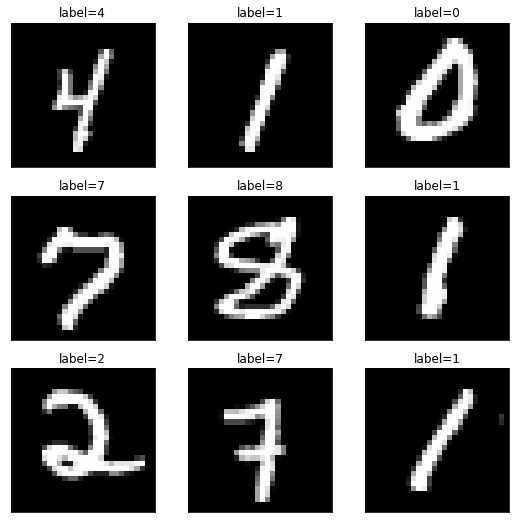

In [6]:
show_img_grid(
    [train_ds['image'][idx] for idx in range(9)],
    [f'label={train_ds["label"][idx]}' for idx in range(9)],
)

In [7]:
print("The mean     of the data stored in the images are: ", np.mean(train_ds['image']))
print("The variance of the data stored in the images are: ", np.var(train_ds['image']))

The mean     of the data stored in the images are:  33.318421449829934
The variance of the data stored in the images are:  6172.850482291347


We have seen that the data is stored in uint8 (an *unsigned* 8-bit integer which can take values from 0 to 255 ).

However it is often preferable when working with Neural Networks to work with floating-point values with values around 0 and variance approximately 1. The reasons are 2:

 - modern CPUs (and to an extent GPUs) are often faster at working with batches (blocks) of floating-point numbers rather than integers [caveats apply]
 - Many nonlinear functions used in machine-learning have the nonlinear crossover aroud ~0 or ~1/2, so we want our data to be spread around those values
 - Most research about how to initialize neural-network layers assumes that the input data has mean 0 and variance 1, so to exploit those results we have to rescale our data

In [8]:
# Therefore... let's convert the data!
train_ds['image'] = jnp.float32(train_ds['image']) / 255.
test_ds['image'] = jnp.float32(test_ds['image']) / 255.

In [9]:
print(f"The training dataset has shape: {train_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print(f"The test     dataset has shape: {test_ds['image'].shape} and dtype {train_ds['image'].dtype}")

print("The mean     of the data stored in the images are: ", np.mean(train_ds['image']))
print("The variance of the data stored in the images are: ", np.var(train_ds['image']))

The training dataset has shape: (60000, 28, 28, 1) and dtype float32
The test     dataset has shape: (10000, 28, 28, 1) and dtype float32
The mean     of the data stored in the images are:  0.13066326
The variance of the data stored in the images are:  0.09471572


## 2 - The model (Neural Network)

We want now to define the Model.
We will use Flax to do that.

We want our network to return a probability distribution for the input to correspond to one of several output labels.

e.g: if $x$ is an image, then $f : \mathbb{R}^{28\times 28}\rightarrow \mathbb{R}^{10}$ and $f^{(i)}(x)$ is the probability that the image $x$ represents a $i\in[0,9]$

To make the output of the network a probability distribution, we can use a softmax function, defined as

$$
\sigma_i(x) = \frac{e^{x_i}}{\sum_i^K e^{x_i} }  \text{   for  } i\in [1,K] \text{ and } x\in\mathbb{R}^K
$$

We want to use a Feedforward network with 2 Dense Layers, relu-nonlinearity and output softmax using Flax.


In [11]:
import jax
import jax.numpy as jnp

# We import flax.linen as nn
# The reason is that flax.nn is old and deprecated and will be removed one day
import flax.linen as nn

In [30]:
# A Flax model must be a class sub-classing nn.Module
class Model(nn.Module):
    
    # We can have some attributes of the Model. 
    # Those are considered compile-time constants and must be hashable
    # They are useful to define some variables that might be changed often
    hidden_width : int = 1024
    """
    The width of the hidden dense layers in the neural network.
    """
    
    n_classes : int = 10
    """
    Number of output classes for the classifier 
    """
    
    # The body of the model must be defined using the `@nn.compact` decorator.
    # Just think of it as boilerplate, and if you are curious, check out
    # Flax documentation
    @nn.compact
    def __call__(self, x):
        """
        This function should evaluate the result of the model for an input image
        x or a batch of images x.
        
        x has shape (28,28,1) or (N, 28, 28, 1)
        """
        # we first ensure a single image is a 4-tensor
        x = x.reshape(-1, 28, 28, 1)
        # Then flatten the x/y/channels dimensions
        x = x.reshape((x.shape[0], -1))
        
        # First dense layer with large output
        x = nn.Dense(features=self.hidden_width)(x)
        
        # First nonlinear activation function
        x = nn.relu(x)
        
        # Last dense layer with n_classes output
        x = nn.Dense(features=self.n_classes)(x)
        
        # transform the output to be a log-probability distribution
        return nn.log_softmax(x)

Let's initialize the model:
 
 - We need a seed for the RNG that generates the initial weights
 - We need a sample input

In [31]:
seed = 123

model = Model(hidden_width = 1024, n_classes=10)

key = jax.random.PRNGKey(seed)
sample_input = jnp.ones([1, 28, 28, 1])

pars = model.init(key, sample_input)

we can inspect the parameters `pars`:

In [32]:
pars['params']['Dense_1']['kernel'].shape

(1024, 10)

In [33]:
# sample application:
jnp.exp(model.apply(pars, jnp.ones([1, 28, 28, 1])))

DeviceArray([[0.07704171, 0.08986449, 0.07054991, 0.04636909, 0.30741608,
              0.064256  , 0.10086796, 0.06952595, 0.10017835, 0.07393045]],            dtype=float32)

In [34]:
jnp.exp(model.apply(pars, jnp.ones([1, 28, 28, 1]))).sum()

DeviceArray(1.0000001, dtype=float32)

## 3 - Writing the loss function

We now want to take as a loss function the distance between the _predicted_ probability given by the model $q_W^{(i)}(x)$ and the actualy probabilith $p^{(i)}(x)$.

The actual probability is a delta function: it is zero for every label except for the correct one, for which it is 1.

To perform this, we can use one-hot encoding, which takes an integer value in $i\in[0..K]$ and returns a vector in $R^K$ where only the i-th component is 1 and the other are zero: $v_j = \delta_{i,j}$.

See the examples below:

In [35]:
for i in range(5):
    print(f"{i} becomes: {jax.nn.one_hot(i, 5)}")

0 becomes: [1. 0. 0. 0. 0.]
1 becomes: [0. 1. 0. 0. 0.]
2 becomes: [0. 0. 1. 0. 0.]
3 becomes: [0. 0. 0. 1. 0.]
4 becomes: [0. 0. 0. 0. 1.]


For the loss function, i'll draw from my vast knowledge of loss functions (aka: [here](https://optax.readthedocs.io/en/latest/api.html)) and choose `optax.softmax_cross_entropy`.

However, for the sake of completeness, i'll write it down here by hand.

`?optax.softmax_cross_entropy`
> Computes the softmax cross entropy between sets of logits and labels.
>
>Measures the probability error in discrete classification tasks in which
>the classes are mutually exclusive (each entry is in exactly one class).
>For example, each CIFAR-10 image is labeled with one and only one label:
>an image can be a dog or a truck, but not both.
>
>References:
> [Goodfellow et al, 2016](http://www.deeplearningbook.org/contents/prob.html)
>
>Args:
>
>  logits: unnormalized log probabilities.
>
>  labels: a valid probability distribution (non-negative, sum to 1), e.g a
>    one hot encoding of which class is the correct one for each input.


The cross entropy between an approximate distribution $P_W(x)$ and a target distribution $Q(x)$ is defined as 

$$
\mathcal{L}(W) = - \langle log P_W(x) \rangle_{x \approx Q(x)} = - \sum_{x \approx Q(x)} log P_W(x)
$$

In [36]:
# The loss function that we will use
def cross_entropy(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [37]:
def loss_fn(params, images, labels):
    """
    Loss function minimised during training of the model.
    """
    # compute the output of the model, which gives the 
    # log-probability distribution over the possible classes (0...9)
    logits = model.apply({'params': params}, images)
    # feed it to the cross_entropy
    return cross_entropy(logits=logits, labels=labels)

def compute_metrics(*, logits, labels):
    """
    Compute metrics of the model during training.
    
    Returns the loss and the accuracy.
    """
    loss = cross_entropy(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

## 4 - Create the setup and training loop

We need to define some functions to create the initial state and we need to define a function to execute one training step, and the whole training loop.

For the optimiser, we use optimisers defined in 

In [38]:
import optax
from flax.training import train_state  # Useful dataclass to keep train state

def create_train_state(rng, optimiser):
    """Creates initial `TrainState`, holding the current parameters, state of the
    optimiser and other metadata.
    """
    # Construct the model parameters
    params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
        
    # Package all those informations in the model state
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=optimiser)


In [39]:
@jax.jit
def eval_metrics(params, batch):
    """
    This function evaluates the metrics without training the model.
    
    Used to check the performance of the network on training and test datasets.
    """
    logits = model.apply({'params': params}, batch['image'])
    return compute_metrics(logits=logits, labels=batch['label'])

In [40]:
# Partial is handy as it can be used to 'fix' some arguments to a function.
# so partial(f, x)(y) == f(x,y)
from functools import partial

@jax.jit
def train_step(state, batch):
    """
    Train for a single step.
    
    The input images `batch` should not be too large, otherwise we will run
    out of memory. Therefore the input should be 'batched', meaning should be
    separated into small blocks of ~hundreds (instead of tens of thousands)
    iamges.
    """
    
    # Fix some arguments to the loss function (so that the only 'free' parameter is
    # the parameters of the network.
    _loss_fn = partial(loss_fn, images=batch['image'], labels=batch['label'])
    
    # construct the function returning the loss value and gradient.
    val_grad_fn = jax.value_and_grad(_loss_fn)
    
    # compute loss and gradient
    loss, grads = val_grad_fn(state.params)
    
    # update the state parameters with the new gradients
    # objects are immutable so the output of this function is a different
    # object than the starting one.
    state = state.apply_gradients(grads=grads)
    
    # Evaluate the network again to get the log-probability distribution
    # over the batch images
    metrics = eval_metrics(state.params, batch)
    
    return state, metrics

In [41]:
def train_epoch(state, train_ds, batch_size, epoch, rng, *, max_steps=None):
    """Train for a single `epoch`.
    
    And epoch is composed of several steps, where every step is taken by updating
    the network parameters with a small mini-batch.
    """
    
    # total number of training images
    train_ds_size = len(train_ds['image'])
    
    # Compute how many steps are present in this epoch.
    # In one epoch we want to go through the whole dataset.
    steps_per_epoch = train_ds_size // batch_size

    # Truncate the number of steps (used to speed up training)
    # Sometimes we might want not to go through the whole dataset
    # in an epoch.
    if max_steps is not None:
        steps_per_epoch = min(steps_per_epoch, max_steps)

    # generate a random permutation of the indices to shuffle the training
    # dataset, and reshape it to a set of batches.
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    # execute the training step for every mini-batch
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
            for k in batch_metrics_np[0]}

    return state, epoch_metrics_np


def evaluate_model(params, test_ds):
    """
    evaluate the performance of the model on the test dataset
    """
    metrics = eval_metrics(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

# 5 - Running the optimisation

We will now finally run the optimisation.  Below we will define all the required HyperParameters.

For the optimiser, we pick one from the [optax](https://optax.readthedocs.io) package, which is very comprehensive

In [42]:
# Definition of optimiser HyperParameters

learning_rate = 0.1
"""
Standard SGD step size
"""
momentum = 0.9
"""
Amount of memntum. The maximum effective learning rate will be
$ learning_rate * momentum/(1-momentum)$
"""

# Construct the optimiser
# we use optimisers from the optax package which is a very comprehensive
# optimiser library
optimiser = optax.sgd(learning_rate, momentum)

In [43]:
num_epochs = 10
"""
"""

batch_size = 32
"""
"""

max_steps = 200
"""
Cutoff to the number of steps (minibatches) in an epoch
""";

In [44]:
# Split the rng to get two keys, one to 'shuffle' the dataset at every iteration,
# and one to initialise the network
rng, init_rng = jax.random.split(jax.random.PRNGKey(0))

In [47]:
# Import the TQDM progress bar module using automatic notebook detection
# Otherwise it would not work..
from tqdm.auto import tqdm

state = create_train_state(init_rng, optimiser)

metrics = {"test_loss" : [], "test_accuracy": [], "train_loss":[], "train_accuracy":[]}

with tqdm(range(0, 20 + 1)) as pbar:
    for epoch in pbar:
        # Use a separate PRNG key to permute image data during shuffling
        rng, input_rng = jax.random.split(rng)
        # Run an optimization step over a training batch
        state, train_metrics = train_epoch(state, train_ds, batch_size, epoch, input_rng)
        # Evaluate on the test set after each training epoch
        test_loss, test_accuracy = evaluate_model(state.params, test_ds)
        pbar.write('train epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, train_metrics['loss'], train_metrics['accuracy'] * 100))
        pbar.write(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_accuracy * 100))

        # save data
        metrics["train_loss"].append(train_metrics["loss"])
        metrics["train_accuracy"].append(train_metrics["accuracy"])
        metrics["test_loss"].append(test_loss)
        metrics["test_accuracy"].append(test_accuracy)

    

  0%|          | 0/21 [00:00<?, ?it/s]

train epoch: 0, loss: 0.1496, accuracy: 95.72
 test epoch: 0, loss: 0.15, accuracy: 95.52
train epoch: 1, loss: 0.0684, accuracy: 98.13
 test epoch: 1, loss: 0.11, accuracy: 96.63
train epoch: 2, loss: 0.0497, accuracy: 98.63
 test epoch: 2, loss: 0.11, accuracy: 96.95
train epoch: 3, loss: 0.0369, accuracy: 99.02
 test epoch: 3, loss: 0.12, accuracy: 96.91
train epoch: 4, loss: 0.0276, accuracy: 99.29
 test epoch: 4, loss: 0.13, accuracy: 97.08
train epoch: 5, loss: 0.0226, accuracy: 99.40
 test epoch: 5, loss: 0.12, accuracy: 97.31
train epoch: 6, loss: 0.0181, accuracy: 99.55
 test epoch: 6, loss: 0.12, accuracy: 97.60
train epoch: 7, loss: 0.0148, accuracy: 99.61
 test epoch: 7, loss: 0.11, accuracy: 97.83
train epoch: 8, loss: 0.0139, accuracy: 99.64
 test epoch: 8, loss: 0.13, accuracy: 97.46
train epoch: 9, loss: 0.0115, accuracy: 99.72
 test epoch: 9, loss: 0.14, accuracy: 97.35
train epoch: 10, loss: 0.0120, accuracy: 99.71
 test epoch: 10, loss: 0.13, accuracy: 97.81
train ep

KeyboardInterrupt: 

We now want to check the performance of the model

Text(0, 0.5, 'Accuracy')

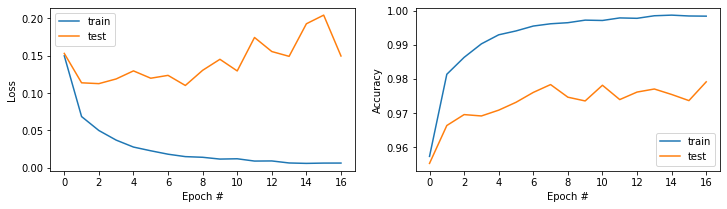

In [48]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(12,3))

axs[0].plot(metrics["train_loss"], label="train")
axs[0].plot(metrics["test_loss"], label="test")
axs[0].legend()
axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("Loss")


axs[1].plot(metrics["train_accuracy"], label="train")
axs[1].plot(metrics["test_accuracy"], label="test")
axs[1].legend()
axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("Accuracy")